In [1]:
import sys
sys.path.append("..")

# basics
import numpy as np
import matplotlib.pyplot as plt
import copy

# custom stuff
import system.from_higher_basis_truncation_tunable_full_cosine as system
import utils.solver as solver
import pulse.tukey as tukey
import utils.expectation_values as expect
import utils.graph as graph
import utils.saver as saver

# parallel utils
from qutip.parallel import parallel_map as parallel_map
from qutip.parallel import parfor as parfor

pass

# Define Pulse Parameters

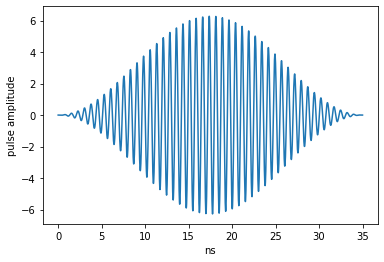

In [16]:
amplitude = 1 * 2 * np.pi
duration = 35

# plot pulse
example_drive_frequency = system.first_energy_spacing/3
tlist = np.linspace(0, duration, duration*50)
tukey.setup(amplitude, example_drive_frequency, 1, tlist)
plt.plot(tlist, tukey.get_pulse(tlist))
plt.xlabel("ns")
plt.ylabel("pulse amplitude")
plt.show()

# Coarse Sweep of Drive Frequency to find center

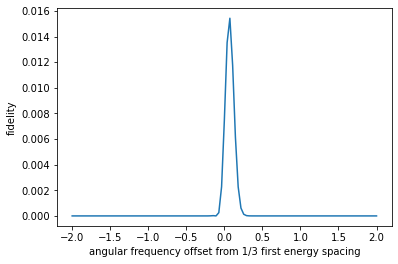

{'fidelity': 0.015429524054312815,
 'offset': 0.07272727272727275,
 'frequency': 8.244496433906747,
 'duration': 35,
 'amplitude': 6.283185307179586}

In [3]:
def vary_offset_tukey(off):
    tlist = np.linspace(0, duration, int(duration*5))
    tukey.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - off, ramp_coef=1, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=tukey.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    return {
        "fidelity": expectation_values[1][-1],
        "offset": off,
        "frequency":  system.first_energy_spacing/3 - off,
        "duration": duration,
        "amplitude": amplitude
    }

offs_to_test = np.linspace(-2, 2, 111)
offset_varying_results = parfor(vary_offset_tukey, offs_to_test)

_fids_off_sweep = []
_offs_off_sweep = []
for result in offset_varying_results:
    _fids_off_sweep.append(result["fidelity"])
    _offs_off_sweep.append(result["offset"])
plt.plot(_offs_off_sweep, _fids_off_sweep)
plt.ylabel("fidelity")
plt.xlabel("angular frequency offset from 1/3 first energy spacing")
plt.show()

best_offset = offset_varying_results[np.argmax(_fids_off_sweep)]["offset"] #used as center for fidelity landscape graph
offset_varying_results[np.argmax(_fids_off_sweep)]

# Generate/Load Fidelity Landscape
Example data is generated using:

amplitude = 1 * 2 * np.pi

duration = 35 

In [4]:
# ~ load existing data ~
tukey_results = saver.load_via_pickle("cosine_fidelity_landscape_example")

In [5]:
# # generate the data and save it
# from tqdm import tqdm
# max_duration = 2000
# _amp = amplitude
# _off = best_offset

# def step(dur):
#     global _amp, _off
#     ramp_coef = 1
#     tlist = np.linspace(0, dur, int(dur*5))
#     tukey.setup(amplitude=_amp, drive_frequency= system.first_energy_spacing/3 - _off, ramp_coef=ramp_coef, tlist=tlist)
#     solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=tukey.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
#     expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
#     return {
#         "fidelity": expectation_values[1][-1],
#         "offset": _off,
#         "frequency":  system.first_energy_spacing/3 - _off,
#         "duration": dur,
#         "amplitude": _amp,
#         "ramp_coef": ramp_coef
#     }

# tukey_results = []
# iterations = 50
# best_offset = offset_varying_results[np.argmax(_fids_off_sweep)]["offset"]
# for i in tqdm(range(0, iterations)):
#     _off = np.linspace(best_offset-0.05, best_offset+0.05, iterations)[i]
#     already_did_this_offset = False
#     for result in tukey_results:
#         if result["offset"] == _off:
#             already_did_this_offset = True
#             break
#     if already_did_this_offset:
#         continue
#     tukey_results += parallel_map(step, np.linspace(5, max_duration, iterations)) #map over durations for given offset and amp

In [6]:
# saver.save_via_pickle(tukey_results, "cosine_fidelity_landscape_example")

In [12]:
def seePoint(frequency, duration):
    # %matplotlib widget
    amps = []
    offs = []
    durs = []
    fids = []
    freqs = []
    all_results_to_graph = copy.deepcopy(tukey_results)
    for result in all_results_to_graph:
        amps.append(result["amplitude"])
        offs.append(result["offset"])
        durs.append(result["duration"])
        fids.append(result["fidelity"])
        freqs.append(result["frequency"] / (2*np.pi))

    fig, axs = plt.subplots(figsize=(12, 6))
    fig.suptitle("Fidelity Landscape for $V_0$ = %.1f$ * 2\pi$" % (amps[-1]/(2*np.pi)), fontsize=18)
    axs.set_xlabel("Drive Frequency (GHz)")
    axs.set_ylabel("Duration (ns)")
    surf = axs.scatter(freqs, durs, c=fids, cmap="viridis", marker="s", s=85)
    cbar = fig.colorbar(surf, shrink=0.5, aspect=10)
    cbar.ax.set_ylabel("Fidelity", rotation=270)
    cbar.ax.get_yaxis().labelpad = 15
    # axs.pcolormesh(offs, durs, fids)

    # put a point on the fidelity landscape
    point_freq = frequency
    point_dur = duration #np.random.choice(durs)
    point_amp = np.random.choice(amps)
    axs.scatter(point_freq, point_dur, c='r')
    point_freq *= 2*np.pi

    plt.show()

    # run the individual simulation
    tlist = np.linspace(0, point_dur, int(point_dur*10))
    tukey.setup(point_amp, point_freq, 1, tlist)
    solution = solver.time_evolve(system.H0, system.H1, tukey.pulse_func, tlist, system.starting_state)
    graph.graph_solution(solution, system)
    plt.plot()

    # graph pulse
    # fig, axs = plt.subplots(figsize=(12, 4))
    # axs.set_xlabel("Duration (ns)")
    # axs.set_ylabel("Pulse Amplitude")
    # axs.plot(tlist, tukey.get_pulse(tlist))


# Examine Individual Points

Simply change the frequency and duration parameters to move the point

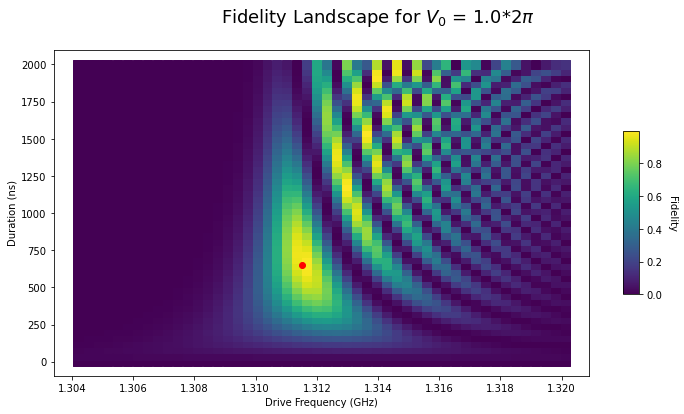

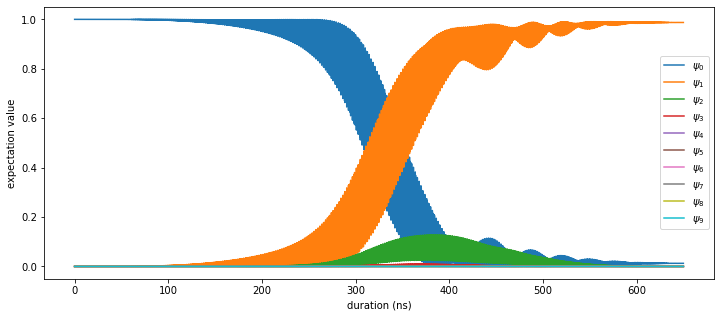

In [13]:
importlib.reload(graph)
frequency = 1.3115
duration = 650
seePoint(frequency, duration)

## Important Behaviors to Notice
1. In between, fringes we have adiabatic evolution, but just ending at wrong point of oscillation
2. Outside fringes, we are also adiabatic

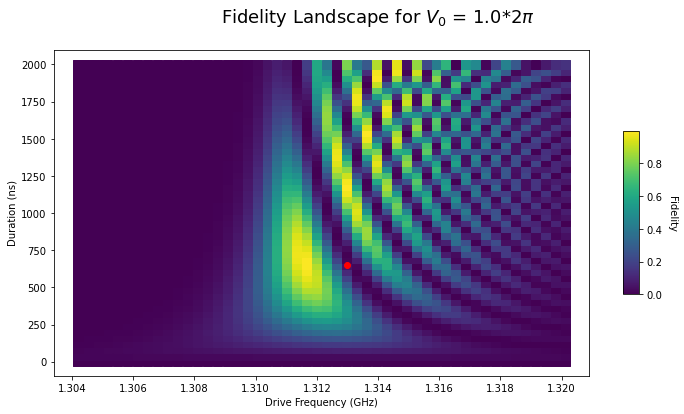

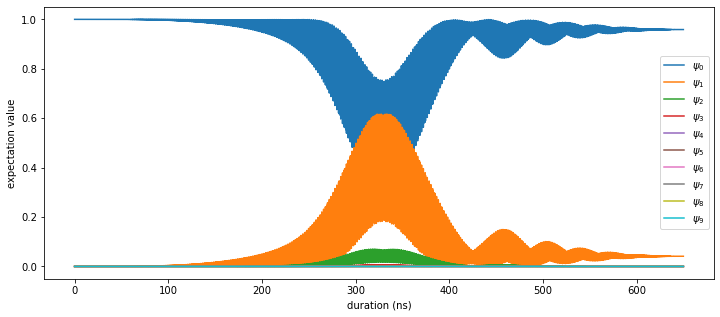

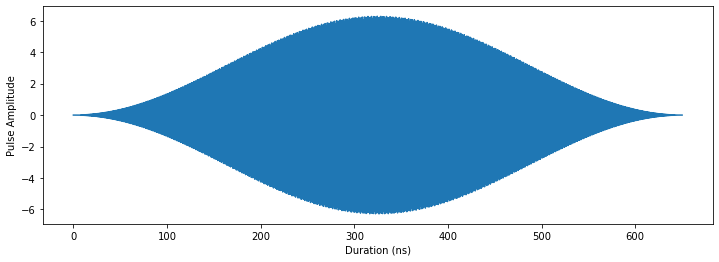

In [9]:
#1 
seePoint(1.313, 650)

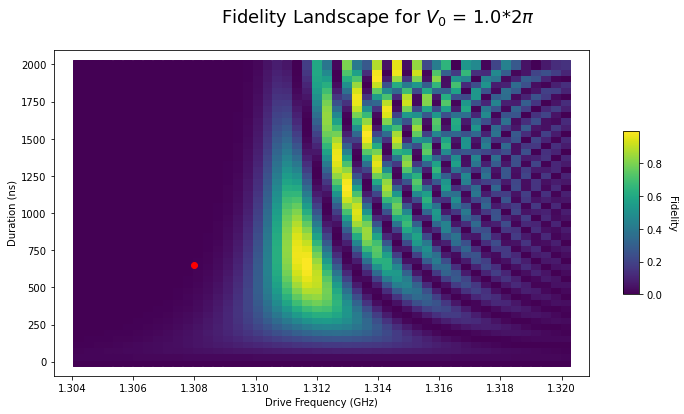

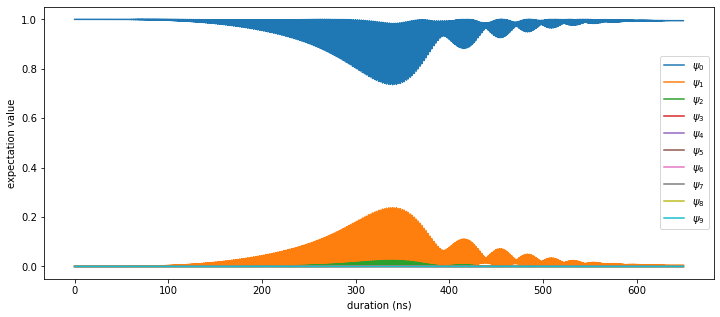

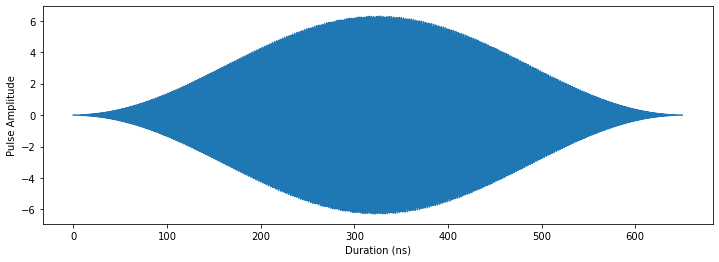

In [10]:
#2 
seePoint(1.308, 650)

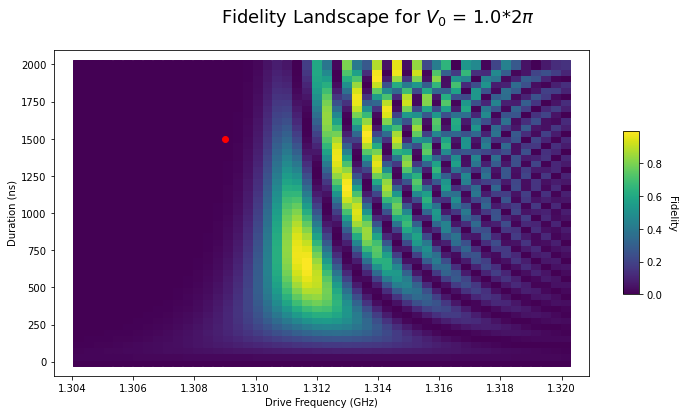

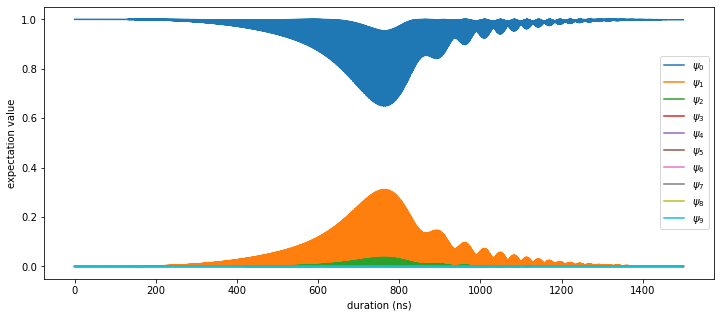

In [14]:
#2 
seePoint(1.309, 1500)

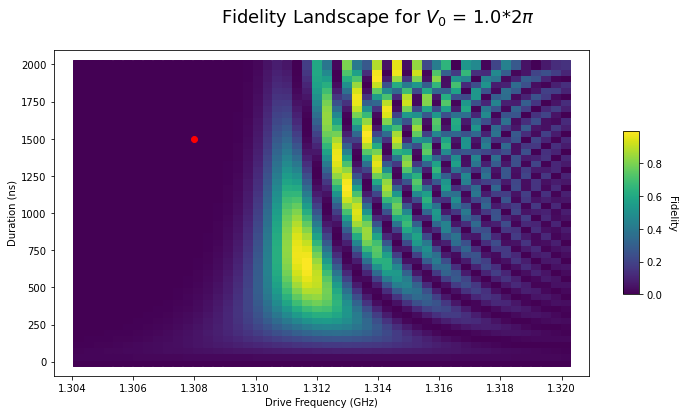

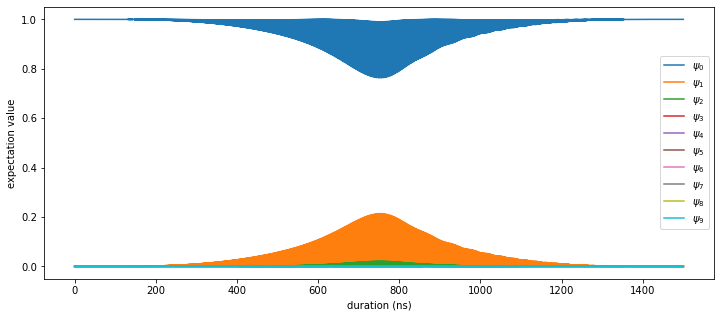

In [15]:
#2 
seePoint(1.308, 1500)